# Music recommender system

One of the most used machine learning algorithms is recommendation systems. A **recommender** (or recommendation) **system** (or engine) is a filtering system which aim is to predict a rating or preference a user would give to an item, eg. a film, a product, a song, etc.

Which type of recommender can we have?   

There are two main types of recommender systems: 
- Content-based filters
- Collaborative filters
  
> Content-based filters predicts what a user likes based on what that particular user has liked in the past. On the other hand, collaborative-based filters predict what a user like based on what other users, that are similar to that particular user, have liked.

We have previously developed a content-based recommendation system. Now, we'll look into collaborative filtering. 

### 2) Collaborative filters

Collaborative Filters work with an interaction matrix, also called rating matrix. The aim of this algorithm is to learn a function that can predict if a user will benefit from an item - meaning the user will likely buy, listen to, watch this item.

Among collaborative-based systems, we can encounter two types: **user-item** filtering and **item-item** filtering. 
  
We'll go through the steps for generating a **item-item filtering** music recommender system.

### Importing required libraries

First, we'll import all the required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split

### Reading the files

We are going to use the **[Million Song Dataset](http://millionsongdataset.com/)**, a freely-available collection of audio features and metadata for a million contemporary popular music tracks. 

There are two files that will be interesting for us. The first of them will give us information about the songs. Particularly, it contains the user ID, song ID and the listen count. On the other hand, the second file will contain song ID, title of that song, release, artist name and year. 
We need to merge these two DataFrames. For that aim, we'll use the `song_ID` 

In [3]:
#Read userid-songid-listen_count
song_info = pd.read_csv('https://static.turi.com/datasets/millionsong/10000.txt',sep='\t',header=None)
song_info.columns = ['user_id', 'song_id', 'listen_count']

#Read song  metadata
song_actual =  pd.read_csv('https://static.turi.com/datasets/millionsong/song_data.csv')
song_actual.drop_duplicates(['song_id'], inplace=True)

#Merge the two dataframes above to create input dataframe for recommender systems
songs = pd.merge(song_info, song_actual, on="song_id", how="left")

In [4]:
songs.head()

user_id             song_id  listen_count  \
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995             1   
1  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B             2   
2  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBXHDL12A81C204C0             1   
3  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBYHAJ12A6701BF1D             1   
4  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SODACBL12A8C13C273             1   

             title                        release    artist_name  year  
0         The Cove             Thicker Than Water   Jack Johnson     0  
1  Entre Dos Aguas            Flamenco Para Niños  Paco De Lucia  1976  
2         Stronger                     Graduation     Kanye West  2007  
3   Constellations              In Between Dreams   Jack Johnson  2005  
4     Learn To Fly  There Is Nothing Left To Lose   Foo Fighters  1999

In [5]:
songs = songs[:10000]

In [6]:
songs.to_csv('songs.cvs', index=False)

## Exploring the data

As usual, any data science or machine learning project starts with an exploratory data analysis (EDA). The aim of EDA is to understand and get insights on our data.

We'll first inspect the first rows of our `DataFrame`.

In [7]:
#Explore first rows
songs.head()

user_id             song_id  listen_count  \
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995             1   
1  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B             2   
2  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBXHDL12A81C204C0             1   
3  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBYHAJ12A6701BF1D             1   
4  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SODACBL12A8C13C273             1   

             title                        release    artist_name  year  
0         The Cove             Thicker Than Water   Jack Johnson     0  
1  Entre Dos Aguas            Flamenco Para Niños  Paco De Lucia  1976  
2         Stronger                     Graduation     Kanye West  2007  
3   Constellations              In Between Dreams   Jack Johnson  2005  
4     Learn To Fly  There Is Nothing Left To Lose   Foo Fighters  1999

Then, we'll check how many observions there are in the dataset.

In [8]:
#Get total observations
print(f"There are {songs.shape[0]} observations in the dataset")

There are 10000 observations in the dataset


Now, we should perform some cleaning steps. But looking at the dataset, we can see that there is no missing values.

In [9]:
songs.isnull().sum()

user_id         0
song_id         0
listen_count    0
title           0
release         0
artist_name     0
year            0
dtype: int64

And most of the columns contain strings.

In [10]:
songs.dtypes

user_id         object
song_id         object
listen_count     int64
title           object
release         object
artist_name     object
year             int64
dtype: object

Let's start exploring some characteristics of the dataset: 

- Unique songs:

In [11]:
#Unique songs
print(f"There are {songs['title'].unique().shape[0]} unique songs in the dataset")

There are 5038 unique songs in the dataset


- Unique artists:

In [12]:
#Unique artists
print(f"There are {songs['artist_name'].unique().shape[0]} unique artists in the dataset")

There are 1994 unique artists in the dataset


- Unique users:

In [13]:
#Unique users
print(f"There are {songs['user_id'].unique().shape[0]} unique songs in the dataset")

There are 365 unique songs in the dataset


We'll go ahead and explore the popularity of songs and artists.

### Most popular songs

How do we determine which are the most popular songs? For this task, we'll count how many times each song appears. Note that while we are using  `listen_count`, we only care about the number of rows, we don't consider the number present in that row. This number represents how many times one user listen to the same song.

In [14]:
#count how many rows we have by song, we show only the ten more popular songs 
ten_pop_songs = songs.groupby('title')['listen_count'].count().reset_index().sort_values(['listen_count', 'title'], ascending = [0,1])
ten_pop_songs['percentage']  = round(ten_pop_songs['listen_count'].div(ten_pop_songs['listen_count'].sum())*100, 2)

In [15]:
ten_pop_songs = ten_pop_songs[:10]
ten_pop_songs

title  listen_count  \
3576                                      Sehr kosmisch            45   
4995                                     You're The One            36   
4577                                               Undo            32   
1044                     Dog Days Are Over (Radio Edit)            28   
3571                                            Secrets            28   
4282                                      The Scientist            27   
4611                                       Use Somebody            27   
3399                                            Revelry            26   
1355                                          Fireflies            24   
1811  Horn Concerto No. 4 in E flat K495: II. Romanc...            23   

      percentage  
3576        0.45  
4995        0.36  
4577        0.32  
1044        0.28  
3571        0.28  
4282        0.27  
4611        0.27  
3399        0.26  
1355        0.24  
1811        0.23

In [16]:
labels = ten_pop_songs['title'].tolist()
counts = ten_pop_songs['listen_count'].tolist()

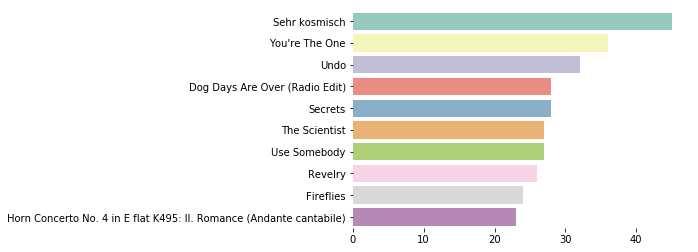

In [17]:
plt.figure()
sns.barplot(x=counts, y=labels, palette='Set3')
sns.despine(left=True, bottom=True)

### Most popular artist

For the next task, we'll count how many times each artist appears. Again, we'll count how many times the same artist appears.

In [18]:
#count how many rows we have by artist name, we show only the ten more popular artist 
ten_pop_artists  = songs.groupby(['artist_name'])['listen_count'].count().reset_index().sort_values(['listen_count', 'artist_name'], 
                                                                                                ascending = [0,1])

In [19]:
ten_pop_artists = ten_pop_artists[:10]
ten_pop_artists

artist_name  listen_count
383                 Coldplay           173
431                Daft Punk           138
1681          The Black Keys           126
1731             The Killers           117
979            Kings Of Leon           108
659   Florence + The Machine           105
577                   Eminem            80
1001         LCD Soundsystem            66
1292             OneRepublic            64
414                 Cut Copy            62

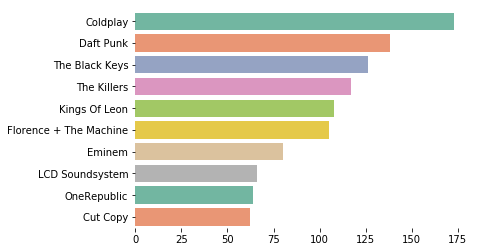

In [20]:
plt.figure()
labels = ten_pop_artists['artist_name'].tolist()
counts = ten_pop_artists['listen_count'].tolist()
sns.barplot(x=counts, y=labels, palette='Set2')
sns.despine(left=True, bottom=True)

### Listen count by user

We can also get some other information from the feature `listen_count`. We will answer the folloging questions:

**How many times on average the same user listen to a same song?**

In [21]:
print(f"On average, a user listen to the same song {songs['listen_count'].mean()} times")

On average, a user listen to the same song 2.9911 times


We can also check the distribution of `listen_count`:

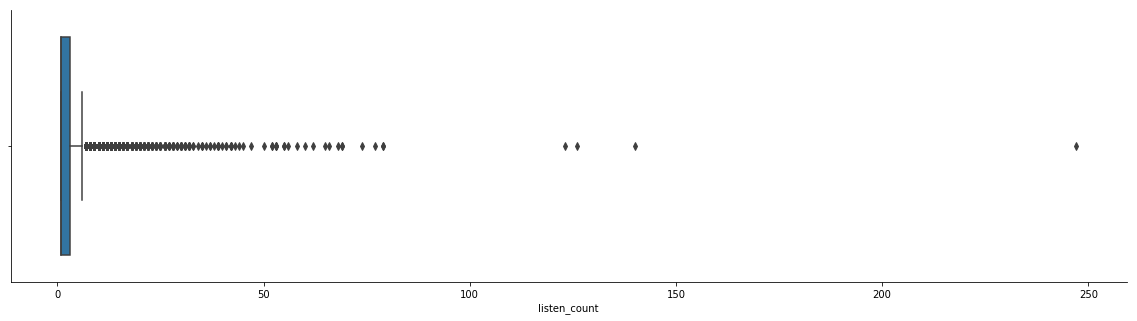

In [22]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='listen_count', data=songs)
sns.despine()

**What was the maximum times the same user listen to a same song?**

In [23]:
print(f"The maximum times the same user listened to the same songs was as follows:")
songs.sort_values('listen_count', ascending=False)[['title',  'listen_count']][:10]

The maximum times the same user listened to the same songs was as follows:


title  listen_count
7520                                Waiting For A Dream           247
3616                                              Times           140
1639                                              Fools           126
9637                                     You're The One           123
9645  Catch You Baby (Steve Pitron & Max Sanna Radio...            79
5347                                     You're The One            79
2000                                    I C Love Affair            77
9643                                        El Cuatrero            74
2821                                               Undo            69
8073              How Am I Supposed To Live Without You            69

So, we know that we want to predict songs. So, in order to have all the information in only one column, we'll concatenate the song `title` with the `artist_name`. We'll assign the resultant string to the new column `song`.

In [24]:
#Concatenate title and artist name. Assign it to new columns
songs['song'] = songs['title'] + "-" + songs["artist_name"]